In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import fsolve
from scipy.special import digamma
%matplotlib inline
from ct_charachterization.utility.utils import central_gamma_pdf
from glob import glob
import pydicom as dicom
import dicom_numpy
import numpy as np
import SimpleITK as sitk
from matplotlib import pyplot as plt
from scipy.stats import mode

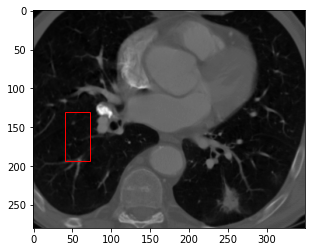

In [2]:
import matplotlib.patches as patches
img = np.load(f'''../resources/luna_cropped.npy''')
fig1, ax1 = plt.subplots(1)
ax1.imshow(img, cmap='gray')
rect = patches.Rectangle((40, 130),32,64,linewidth=1,edgecolor='r',facecolor='none')
ax1.add_patch(rect)
plt.show()

Till the end, we will just work with voxels inside the red rectangle shown above. We will divide it into 2 neighborhoods.

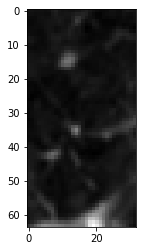

(64, 32)
-977 -844.8076171875 299


In [3]:
from copy import deepcopy

neighborhood = deepcopy(img[130:194, 40:72])
plt.imshow(neighborhood, cmap='gray')
plt.show()
print(neighborhood.shape)
print(np.min(neighborhood), np.mean(neighborhood), np.max(neighborhood))

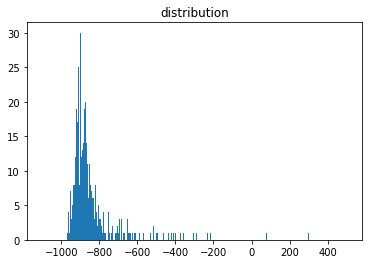

In [4]:
flat = neighborhood.flatten()
ax = plt.subplot(1, 1, 1)
ax.hist(flat, bins=list(np.arange(-1100, 500, 1)))
plt.title("distribution")
plt.show()

In [5]:
from scipy.stats import mode
mode(flat)

ModeResult(mode=array([-899], dtype=int16), count=array([30]))

In [6]:
delta = - 1030
mu = np.array([-987, -810, -540, -370, -160, 0, 100, 240, 340]) - delta
J = len(mu)

# Global Theta and Gamma
First, we want to find the global theta (according to the paper) for the image consisting of both neighborhoods.

According to their [followup paper](https://aapm.onlinelibrary.wiley.com/doi/full/10.1002/mp.13578):

![initial value for theta](../resources/figs/initial.png)

In [7]:
initial_alpha = np.ones((J)) * 2
initial_beta = mu/initial_alpha
initial_pi = np.ones((J)) / J

# centering and expanding dims
y = np.expand_dims(neighborhood, axis=-1) - delta
global_alpha = np.expand_dims(np.expand_dims(initial_alpha, axis=0), axis=0)
global_beta = np.expand_dims(np.expand_dims(initial_beta, axis=0), axis=0)
global_pi = np.expand_dims(np.expand_dims(initial_pi, axis=0), axis=0)

Initial value for gamma:

![](../resources/figs/initial_gamma.png)

Where eqaution 18 and 19 are:

![](../resources/figs/eq18_eq19.png)

In [8]:
global_gamma = global_pi * central_gamma_pdf(y, alpha=global_alpha, beta=global_beta)
global_gamma = global_gamma / np.expand_dims(np.sum(global_gamma, axis=-1), axis=-1)

![](../resources/figs/finding_alpha.png)

In [9]:
def _get_alphas_solution(right_hand_side, previous_alpha):
    alpha_optimizer = lambda alpha_var: right_hand_side - (np.log(alpha_var) - digamma(alpha_var))
    alpha_solution = fsolve(alpha_optimizer, previous_alpha)
    return alpha_solution

vectorized_get_alphas_solution = np.vectorize(_get_alphas_solution)

![](../resources/figs/while.png)

In [10]:
def do_iterations(y, mu, alpha, beta, pi, gamma):
    expanded_mu = np.expand_dims(np.expand_dims(mu, axis=0), axis=0)
    err = np.Infinity
    tol = 0.000001
    n = 0
    max_iter = 5
    while err > tol and n < max_iter:
        n += 1
        right_hand_side = ((np.sum(gamma*y/expanded_mu, axis=(0,1)) - np.sum(gamma*np.log(y/expanded_mu), axis=(0,1))) / (np.sum(gamma, axis=(0,1)))) - 1
        right_hand_side = np.expand_dims(np.expand_dims(right_hand_side, axis=0), axis=0)
        new_alpha = vectorized_get_alphas_solution(right_hand_side, alpha)
        new_beta = expanded_mu / new_alpha
        new_pi = (np.sum(gamma, axis=(0,1))) / y.size
        err = np.linalg.norm(np.array([new_alpha.ravel(), new_beta.ravel(), new_pi.ravel()]) - np.array([alpha.ravel(), beta.ravel(), pi.ravel()])) / np.linalg.norm(np.array([alpha.ravel(), beta.ravel(), pi.ravel()]))
        gamma = pi * central_gamma_pdf(y, alpha=alpha, beta=beta)
        gamma = gamma / np.expand_dims(np.sum(gamma, axis=-1), axis=-1)
        alpha = new_alpha
        beta = new_beta
        pi = new_pi
        print(n, err)
    print()
    return alpha, beta, pi, gamma

In [11]:
global_alpha, global_beta, global_pi, global_gamma = do_iterations(y, mu, global_alpha, global_beta, global_pi, global_gamma)

1 0.1171781766868034
2 5.389653413687787e-16



<ipython-input-9-b76b0093ae12>:2: RuntimeWarning: invalid value encountered in log
  alpha_optimizer = lambda alpha_var: right_hand_side - (np.log(alpha_var) - digamma(alpha_var))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [12]:
print(np.isnan(np.sum(global_alpha)), np.isnan(np.sum(global_beta)),np.isnan(np.sum(global_pi)), np.isnan(np.sum(global_gamma)))

False False False False


-1008 -987


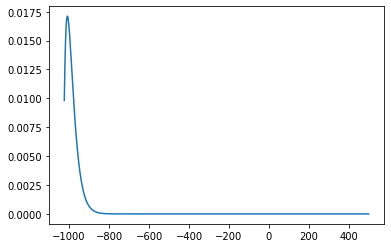

-856 -810


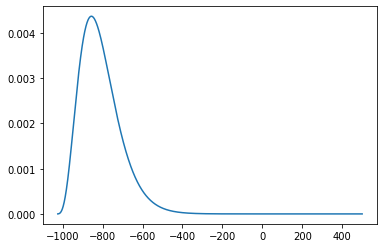

-930 -540


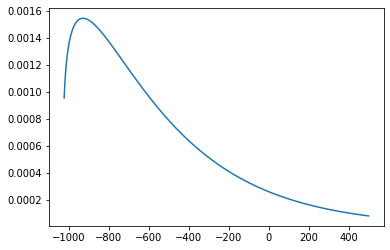

-700 -370


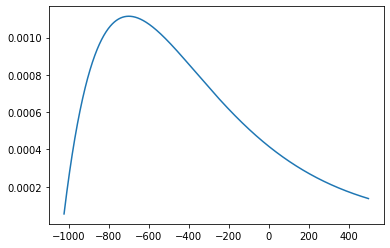

-595 -160


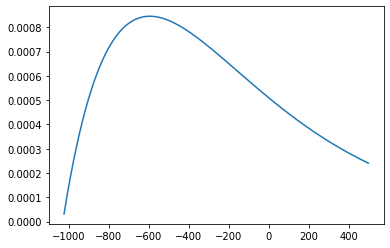

-515 0


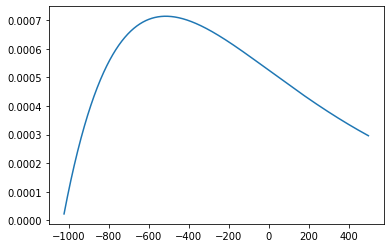

-465 100


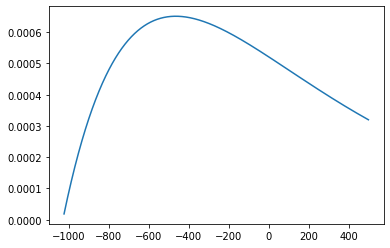

-395 240


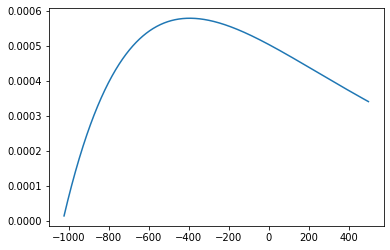

-345 340


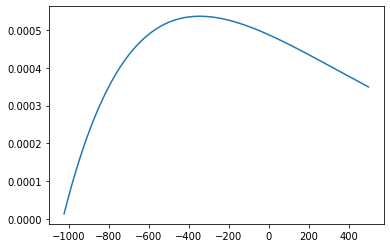

In [13]:
for j in range(J):
    wanted_alpha = global_alpha[0, 0, j]
    wanted_beta = global_beta[0, 0, j]
    xs = np.arange(-1024, 500, 1) - delta
    ys = central_gamma_pdf(xs, wanted_alpha, wanted_beta).ravel()
    plt.plot(xs + delta, ys, '-')
    print(xs[np.argmax(ys)] + delta, mu[j] + delta)
    plt.show()

# Two Neighborhoods
Now, We divide the rectangle into 2 neighborhoods.

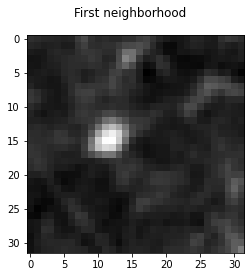

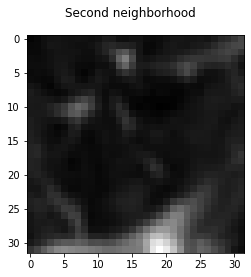

In [14]:
y_1 = y[0:32, :, :]
y_2 = y[32:64, :, :]

plt.imshow(y_1[:,:,0], cmap='gray')
plt.suptitle("First neighborhood")
plt.show()
plt.imshow(y_2[:,:,0], cmap='gray')
plt.suptitle("Second neighborhood")
plt.show()

We use previously found theta values as initial values to find local thetas.

In [15]:
from copy import deepcopy

local_alpha_1 = deepcopy(global_alpha)
local_beta_1 = deepcopy(global_beta)
local_pi_1 = deepcopy(global_pi)
local_gamma_1 = local_pi_1 * central_gamma_pdf(y_1, alpha=local_alpha_1, beta=local_beta_1)

local_alpha_1, local_beta_1, local_pi_1, local_gamma_1 = do_iterations(y_1, mu, local_alpha_1, local_beta_1, local_pi_1, local_gamma_1)




local_alpha_2 = deepcopy(global_alpha)
local_beta_2 = deepcopy(global_beta)
local_pi_2 = deepcopy(global_pi)
local_gamma_2 = local_pi_2 * central_gamma_pdf(y_2, alpha=local_alpha_2, beta=local_beta_2)

local_alpha_2, local_beta_2, local_pi_2, local_gamma_2 = do_iterations(y_2, mu, local_alpha_2, local_beta_2, local_pi_2, local_gamma_2)

1 0.06721523520015361
2 0.0030562421679826814
3 0.013707830607784851
4 0.0022771625063488002
5 0.00939023056693026

1 0.218049437693315
2 0.2575744662694074
3 0.44441930489223236
4 0.17500868603390834
5 0.16517115519438924



<ipython-input-9-b76b0093ae12>:2: RuntimeWarning: invalid value encountered in log
  alpha_optimizer = lambda alpha_var: right_hand_side - (np.log(alpha_var) - digamma(alpha_var))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [16]:
print(np.isnan(np.sum(local_alpha_1)), np.isnan(np.sum(local_beta_1)),np.isnan(np.sum(local_pi_1)), np.isnan(np.sum(local_gamma_1)))
print(np.isnan(np.sum(local_alpha_2)), np.isnan(np.sum(local_beta_2)),np.isnan(np.sum(local_pi_2)), np.isnan(np.sum(local_gamma_2)))

False False False False
False False False False


# Stabilization

According to the algorithm:

![](../resources/figs/stabilizing.png)

In [17]:
def stabilize(y, local_gamma):
    constant_c = 10
    first_local_moment_numerator = np.sum(np.sqrt(y)*local_gamma, axis=(0,1))
    second_local_moment_numerator = np.sum(y*local_gamma, axis=(0,1))
    denumerator = np.sum(local_gamma, axis=(0,1))
    first_local_moment = first_local_moment_numerator / denumerator
    second_local_moment = second_local_moment_numerator / denumerator
    variance = second_local_moment - np.power(first_local_moment, 2)
    y_stab = (constant_c * (np.expand_dims(np.sqrt(y), axis=-1) - first_local_moment) / np.sqrt(variance)) + second_local_moment
    return y_stab

y_stab_1 = stabilize(y_1, local_gamma_1)
y_stab_2 = stabilize(y_2, local_gamma_2)
y_stab = np.empty(tuple(list(y.shape) + [J]))
y_stab[0:32, ...] = y_stab_1
y_stab[32:64, ...] = y_stab_2
y_stab = y_stab + delta

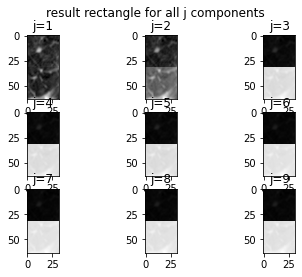

In [18]:
fig, axes = plt.subplots(3, 3)
for a in range(3):
    for b in range(3):
        j = a*3+b
        axes[a, b].set_title(f'j={j+1}')
        axes[a, b].imshow(y_stab[..., j], cmap='gray')
plt.suptitle("result rectangle for all j components")
plt.show()

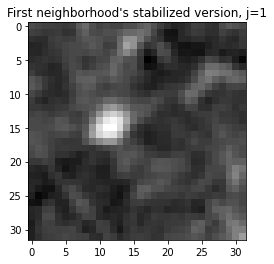

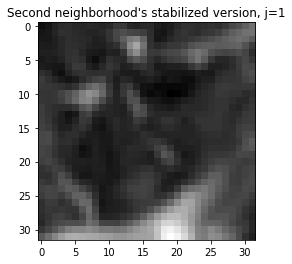

In [19]:
to_show = y_stab_1[..., 0]
plt.imshow(to_show, cmap='gray')
plt.title("First neighborhood's stabilized version, j=1")
plt.show()

to_show = y_stab_2[..., 0]
plt.imshow(to_show, cmap='gray')
plt.title("Second neighborhood's stabilized version, j=1")
plt.show()

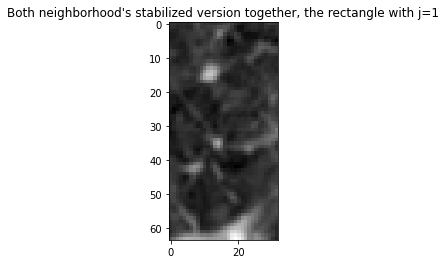

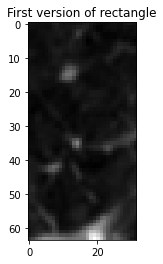

In [26]:
plt.imshow(y_stab[..., 0], cmap='gray')
plt.title("Both neighborhood's stabilized version together, the rectangle with j=1")
plt.show()

plt.imshow(neighborhood, cmap='gray')
plt.title("First version of rectangle")
plt.show()

j=1 min: -942.8129526134046 mean: -903.3464573164576 max: -763.2840818568666
j=2 min: -907.538029527148 mean: -862.0033359981998 max: -758.46142002394
j=3 min: -874.5758083449309 mean: -752.6391011288156 max: -610.344469861395
j=4 min: -819.4451898777638 mean: -704.1328975741409 max: -567.728254009691
j=5 min: -797.8280453931934 mean: -688.5679399632036 max: -558.8786719542713
j=6 min: -786.1243112059018 mean: -652.1247057537953 max: -497.16491674307315
j=7 min: -780.2346364075827 mean: -648.555991170406 max: -496.1096917829375
j=8 min: -773.3531554971383 mean: -645.8625086900088 max: -497.83110092328866
j=9 min: -769.2060425730165 mean: -645.0308416974234 max: -500.44843903518847


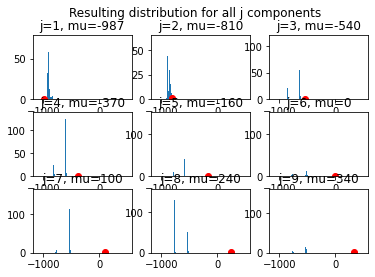

In [25]:
fig, axes = plt.subplots(3, 3)
for a in range(3):
    for b in range(3):
        j = a*3+b
        flat = (y_stab[..., j]).flatten()
        print(f'j={j+1}', 'min:', np.min(flat),'mean:', np.mean(flat),'max:', np.max(flat))
        axes[a, b].set_title(f'j={j+1}, mu={mu[j] + delta}')
        axes[a, b].plot(mu[j] + delta, 1, "or")
        axes[a, b].hist(flat, bins=list(np.arange(-1100, 500, 1)))
fig.suptitle("Resulting distribution for all j components")
plt.show()

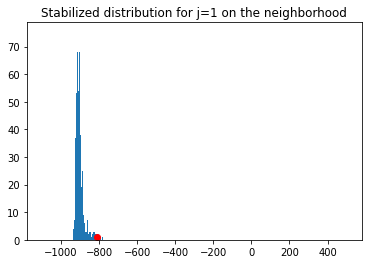

min: -942.8129526134046 mean: -903.3464573164576 max: -763.2840818568666


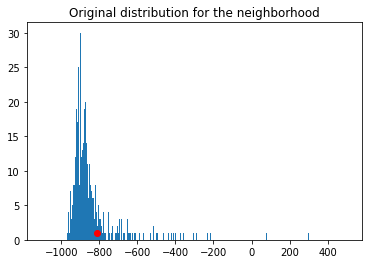

min: -977 mean: -844.8076171875 max: 299


In [22]:
flat = y_stab[..., 0].flatten()
ax = plt.subplot(1, 1, 1)
ax.hist(flat, bins=list(np.arange(-1100, 500, 1)))
ax.plot(mu[1]+delta, 1, "or")
plt.title("Stabilized distribution for j=1 on the rectangle")
plt.show()

print('min:', np.min(flat),'mean:', np.mean(flat),'max:', np.max(flat))


flat = neighborhood.flatten()
ax = plt.subplot(1, 1, 1)
ax.hist(flat, bins=list(np.arange(-1100, 500, 1)))
ax.plot(mu[1]+delta, 1, "or")
plt.title("Original distribution for the rectangle")
plt.show()
print('min:', np.min(flat),'mean:', np.mean(flat),'max:', np.max(flat))

# Replacing
Let's replace the original in the image with the stabilized rectangle!

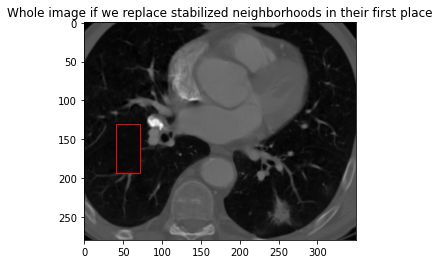

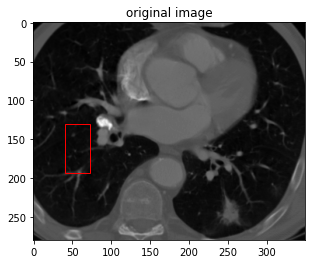

In [23]:
partially_stabilized_img = deepcopy(img)
partially_stabilized_img[130:194, 40:72] = (y_stab[..., 0].squeeze())
fig1, ax1 = plt.subplots(1)
ax1.imshow(partially_stabilized_img, cmap='gray')
rect = patches.Rectangle((40, 130),32,64,linewidth=1,edgecolor='r',facecolor='none')
ax1.add_patch(rect)
plt.title("Whole image if we replace stabilized rectangle in their first place")
plt.show()

fig1, ax1 = plt.subplots(1)
ax1.imshow(img, cmap='gray')
rect = patches.Rectangle((40, 130),32,64,linewidth=1,edgecolor='r',facecolor='none')
ax1.add_patch(rect)
plt.title("original image")
plt.show()

A little bit zoom:

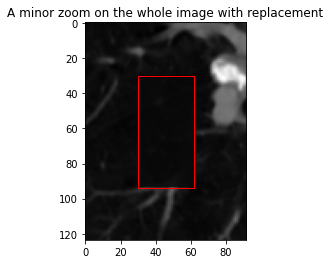

In [24]:
fig1, ax1 = plt.subplots(1)
ax1.imshow(partially_stabilized_img[100:224,10:102], cmap='gray')
rect = patches.Rectangle((30, 30),32,64,linewidth=1,edgecolor='r',facecolor='none')
ax1.add_patch(rect)
plt.title("A minor zoom on the whole image with replacement")
plt.show()

Some blurred spots in the image can be seen instead of original white tissues.

# Conclusion
Going through the third algorithm, you can see that y_stab is a (r * J) matrix (tensor).

![](../resources/figs/stabilizing.png)


They didn't mention how they solve this issue.

While writing this notebook, I realized for each neighborhood n, we can replace y_stab[n,j] at the original image in a way that the jth elements's existence in that neighborhood is the highest probability.

For example, for the neighborhoods in this notebook, the probability that a voxel inside them belongs to the first component (with mu=-987 which is near the lung's hu) was the highest.

Am I right?